In [1]:
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import norm

import matplotlib as mpl
from fold import *
import math
from Fold_Interpolator import *
import pymc as pymc
from bayesian_fourier_series import *
#mpl.rcParams.update({'font.size': 18})
from Modified_Fold import *
from Fold_Interpolator import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

ImportError: No module named Fold_Interpolator

# Figure 2 
<img src="single_fold_proof_of_concept.svg">
Proof of concept 1-D example for a sinusoidal fold geometry. (a) Reference fold shape with a fold
wavelength of 150m and sample locations. (b) Reference fold profile and sample locations representing the
fold rotation angle for the fold geometry in (a). (c) S-Variogram for the structural observations (blue dots in
(a) and (b). The dots represent the variogram for all points at the corresponding step size. The red dots are
the locations identified as being local extrema. The estimated half wavelength is shown by the dashed line.
(d) Interpolated fold shape probability showing the range in solutions sampled with MCMC. (e) Fold rotation
angle profile probability sampled from the posterior using MCMC. (f) Violin plot showing prior and posterior
distributions for the fold wavelength.

In [3]:
#The x location of the data used in the paper has been saved in a numpy array, load this to reproduce the figures 
try:
    print "loading exisitng data"
    x = np.load('figure_2_x_location.npy')
except:
    x  = np.arange(0, 150,1)
    np.random.shuffle(x)
    N = 50
    x = x[:N]
    print "generating data"

loading exisitng data


In [4]:
np.save('figure_2_x_location',x)

In [5]:
wl1= 15.#15.
wl2 = 150.
#N = 100
foldfourier = fourierFold(30,30,wl1,0,40,20,0)
foldfourier2 = fourierFold(30,80,wl2,0,40,20,20)
foldr = foldRotation(foldfourier)
foldr2 = foldRotation(foldfourier2)
x_ = np.linspace(0,300,300)



In [6]:
fold= (foldfourier2.pos(x_))#+foldfourier.pos(x_)
foldpts = (foldfourier2.pos(x))#+foldfourier.pos(x)
x__ = x_
foldrot = (np.gradient(fold))
xv = x#np.array([10.])
xm = np.array([20])
data = DataSet(xv,foldfourier2.pos(xv),x,foldrot[x],xm,foldfourier2.pos(xm),foldrot[xm]) 
foldrot = np.arctan(foldrot)
foldrot*=180.0/np.pi

for i in range(1):
    xx1, yy1 = shake_xy(x,foldrot[x],5)

fourierseries = bayesian_fourier_series_model(xx1,yy1,1)
fourierseries.add_reference_foldshape(x_,fold)
fourierseries.add_reference_foldlocations(x,foldpts)
fourierseries.add_reference_foldprofile(x_,foldrot)
fourierseries.find_wavelength()
#fourierseries.wavelengths= [140.]
print 'Estimated fold wavelengths:',fourierseries.wavelengths

178.8 149.0
Estimated fold wavelengths: [163.89999999999998]


/usr/lib/python2.7/dist-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [7]:
fourierseries.setup_inference()
fourierseries.run_sampler(5000,2500)

 [-----------------100%-----------------] 5000 of 5000 complete in 7.0 sec

True

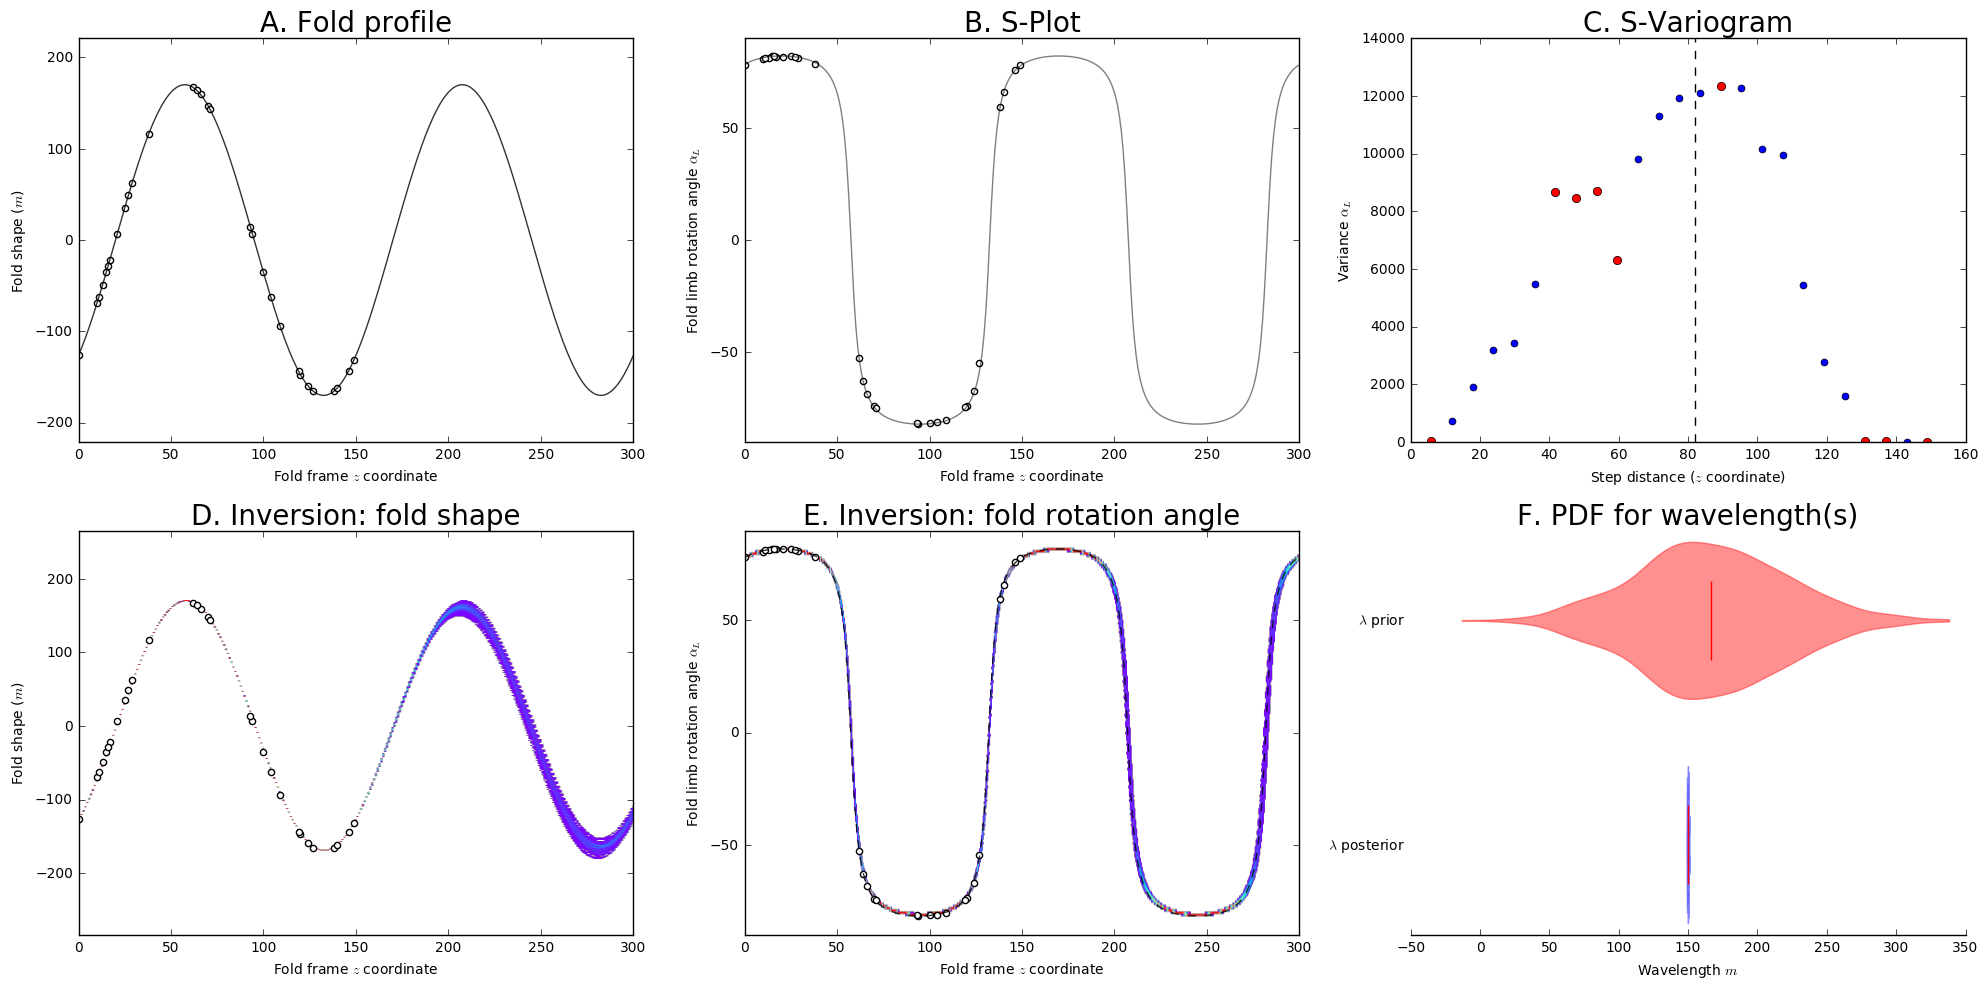

In [8]:
fig = bayesian_fourier_series_figure(fourierseries)
#fourierseries.semivariogram.
fig.plot_variogram()
fig.plot_reference_fold_points()
fig.plot_reference_fold_points('ko',0,1)

fig.plot_reference_fold_profile()
fig.plot_reference_fold_profile_points()
fig.plot_reference_fold_profile_points('ko',1,1)

fig.plot_reference_fold_shape()
fig.ax[0][0].set_title(r'A. Fold profile',fontsize=20)
fig.ax[0][1].set_title(r'B. S-Plot',fontsize=20)
fig.ax[0][2].set_title(r'C. S-Variogram',fontsize=20)

fig.ax[1][1].set_title(r'E. Inversion: fold rotation angle',fontsize=20)
fig.ax[1][0].set_title(r'D. Inversion: fold shape',fontsize=20)
fig.ax[1][2].set_title(r'F. PDF for wavelength(s)',fontsize=20)

fig.ax[0][0].set_xlabel(r'Fold frame $z$ coordinate')
fig.ax[0][1].set_xlabel(r'Fold frame $z$ coordinate')
fig.ax[0][2].set_xlabel(r'Step distance ($z$ coordinate)')

fig.ax[1][2].set_xlabel(r'Wavelength $m$')

fig.ax[0][1].set_ylabel(r'Fold limb rotation angle $\alpha_L$')
fig.ax[0][2].set_ylabel(r'Variance $\alpha_L$')

fig.ax[1][0].set_xlabel(r'Fold frame $z$ coordinate')
fig.ax[1][0].set_ylabel(r'Fold shape ($m$)')
fig.ax[0][0].set_ylabel(r'Fold shape ($m$)')

fig.ax[1][1].set_xlabel(r'Fold frame $z$ coordinate')
fig.ax[1][1].set_ylabel(r'Fold limb rotation angle $\alpha_L$')
H2 = fig.plot_curve_density(0,300)
fig.plot_fold_heat_map(data)


fig.plot_map(0,300,'k--')
colours = ['b-','r-']
temp = fig.ax[0][0]
i = 0

arrays = []
pos = []
labels = []
c = len(fourierseries.wavelengths)/2
for i in range(len(fourierseries.wavelengths)):
    arrays.append(np.random.normal(fourierseries.wavelengths[i],fourierseries.wavelengths[i]/3.,1000))
    labels.append(r"$\lambda$ prior")
    pos.append(c)
    c-=1
    arrays.append(fourierseries.S.trace('qw_%i'%i)[:][:])
    labels.append(r"$\lambda$ posterior")

    pos.append(c)
    c-=1
fig.plot_violin(1,2,labels,pos,arrays)
plt.tight_layout()
for i in range(2):
    for j in range(2):
        fig.ax[i][j].set_xlim(0,300)
fig.ax[1][2].spines['top'].set_visible(False)
fig.ax[1][2].spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
fig.ax[1][2].spines['left'].set_visible(False)
fig.ax[1][2].tick_params(top='off', bottom='on', left='off', right='off', labelleft='on', labelbottom='on')

In [9]:
fig.fig.savefig("single_fold_proof_of_concept.svg")